In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "5"
import os.path as path

import numpy as np

from ExperimentConfig import ExperimentConfig
from Experiment import Experiment
from CombinedExperiment import CombinedExperiment
from typing import List
from Experiment import RaceResult


def run_strategic_races(version: str, election_process: str, cv: float, qv: float, flexibility: float, n_voters: int, n_races: int):
    c = ExperimentConfig(version,
                         election_process,
                         equal_pct_bins=True,
                         candidate_variance=cv,
                         quality_variance=qv,
                         ideology_flexibility = flexibility,
                         sampling_voters=n_voters,
                         model_path=f"exp/{version}/{election_process}-A.mdl.010000.progress")

    x = Experiment(c)
    rr = x.run_strategic_races_par(n_races)
    return rr

def compute_SUE(rr: List[RaceResult]):
    return CombinedExperiment.compute_SUE(rr)

def count_ties(rr: List[RaceResult]) -> float:
    count_of_ties = 0
    for r in rr:
        if r.condorcet_tie:
            count_of_ties += 1
    return count_of_ties / len(rr)

In [5]:
import matplotlib.pyplot as plt
def make_line_plot(data, title, labels,
                   xlabel: str = "Candidate Ideological Flexibility (stddev)",
                   ylabel: str = "Social Utility Efficiency"):
    import matplotlib as mpl
    mpl.rcParams['figure.dpi'] = 300
    n_rows = 1
    n_cols = 1
    fig, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))
    fig.suptitle(title, color="black", fontsize=22)
    fig.set_facecolor("white")

    count = 0
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    axis.tick_params(axis='x', colors="black")

    for i in range(len(data)):
        d = data[i]
        plt.plot(d[0], d[1], label =labels[i])
    plt.legend()

    axis.set_xlabel(xlabel, fontsize=20)
    axis.set_ylabel(ylabel, fontsize=20)

import pickle
def save_results(file_path: str, obj):
    with open(file_path, "wb") as f:
        pickle.dump(obj, f)

def load_results(file_path: str):
    if path.exists(file_path):
        with open(file_path, "rb") as f:
            return pickle.load(f)
    else:
        return None

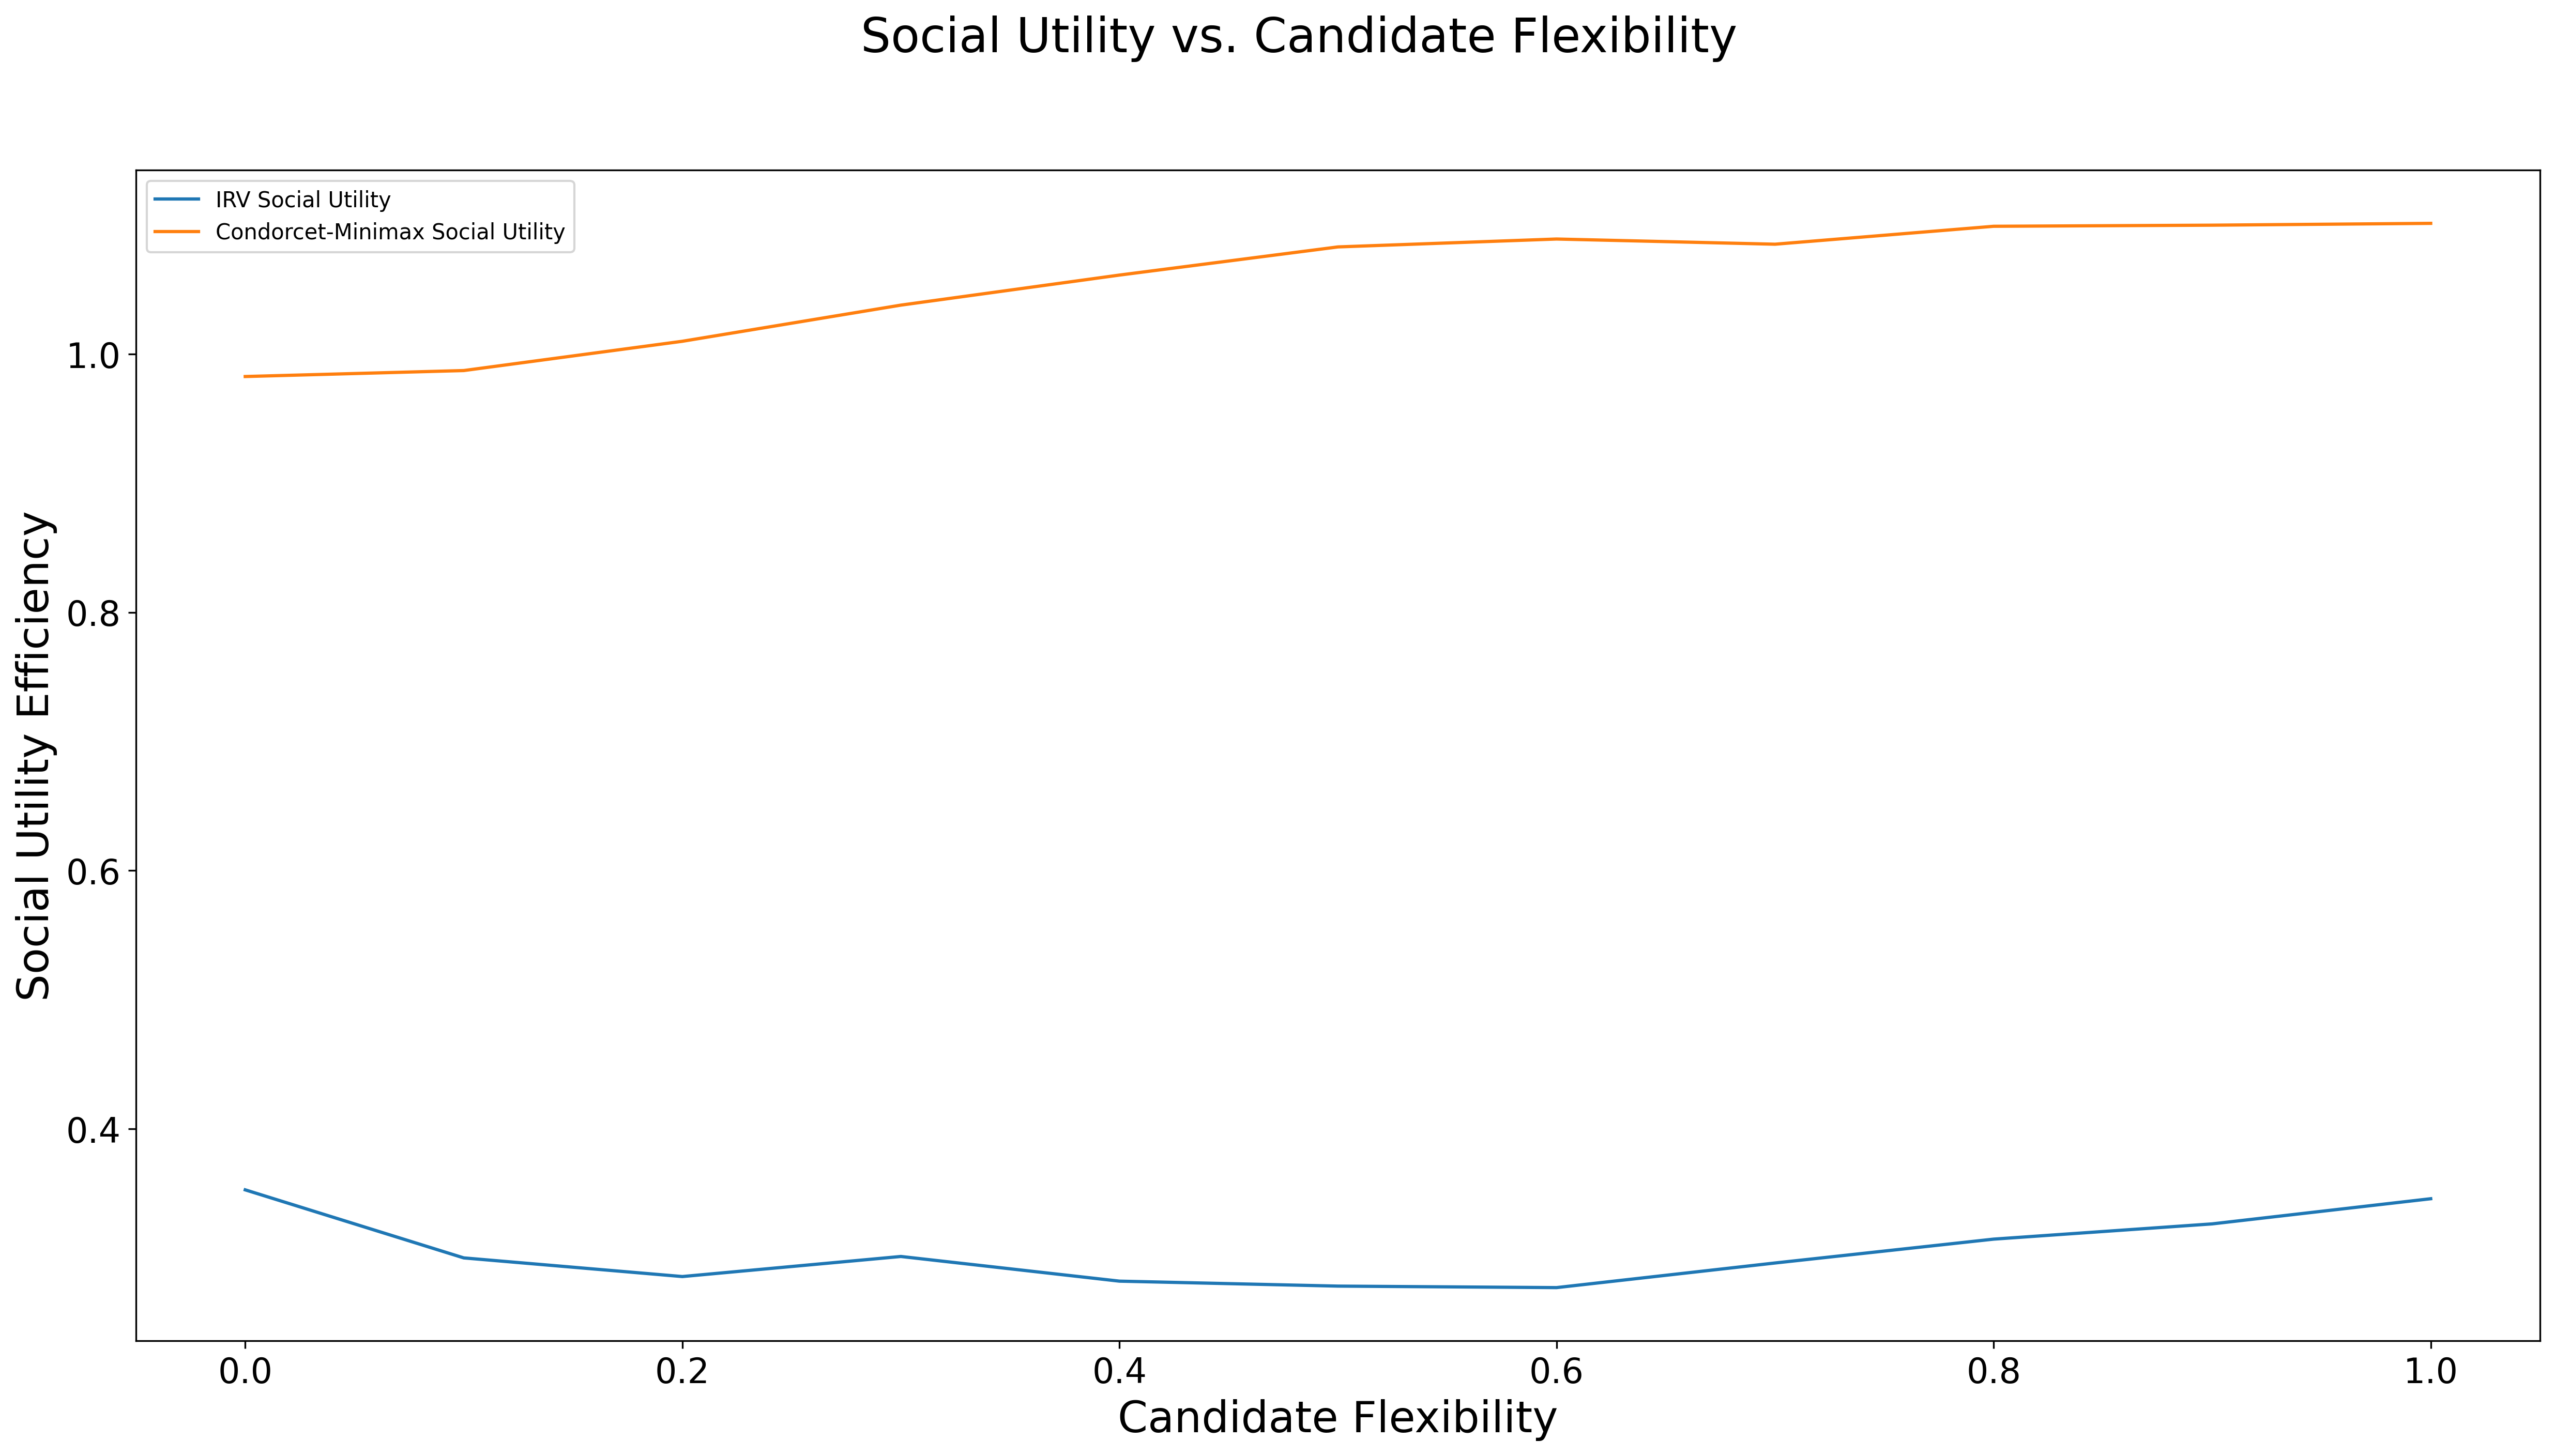

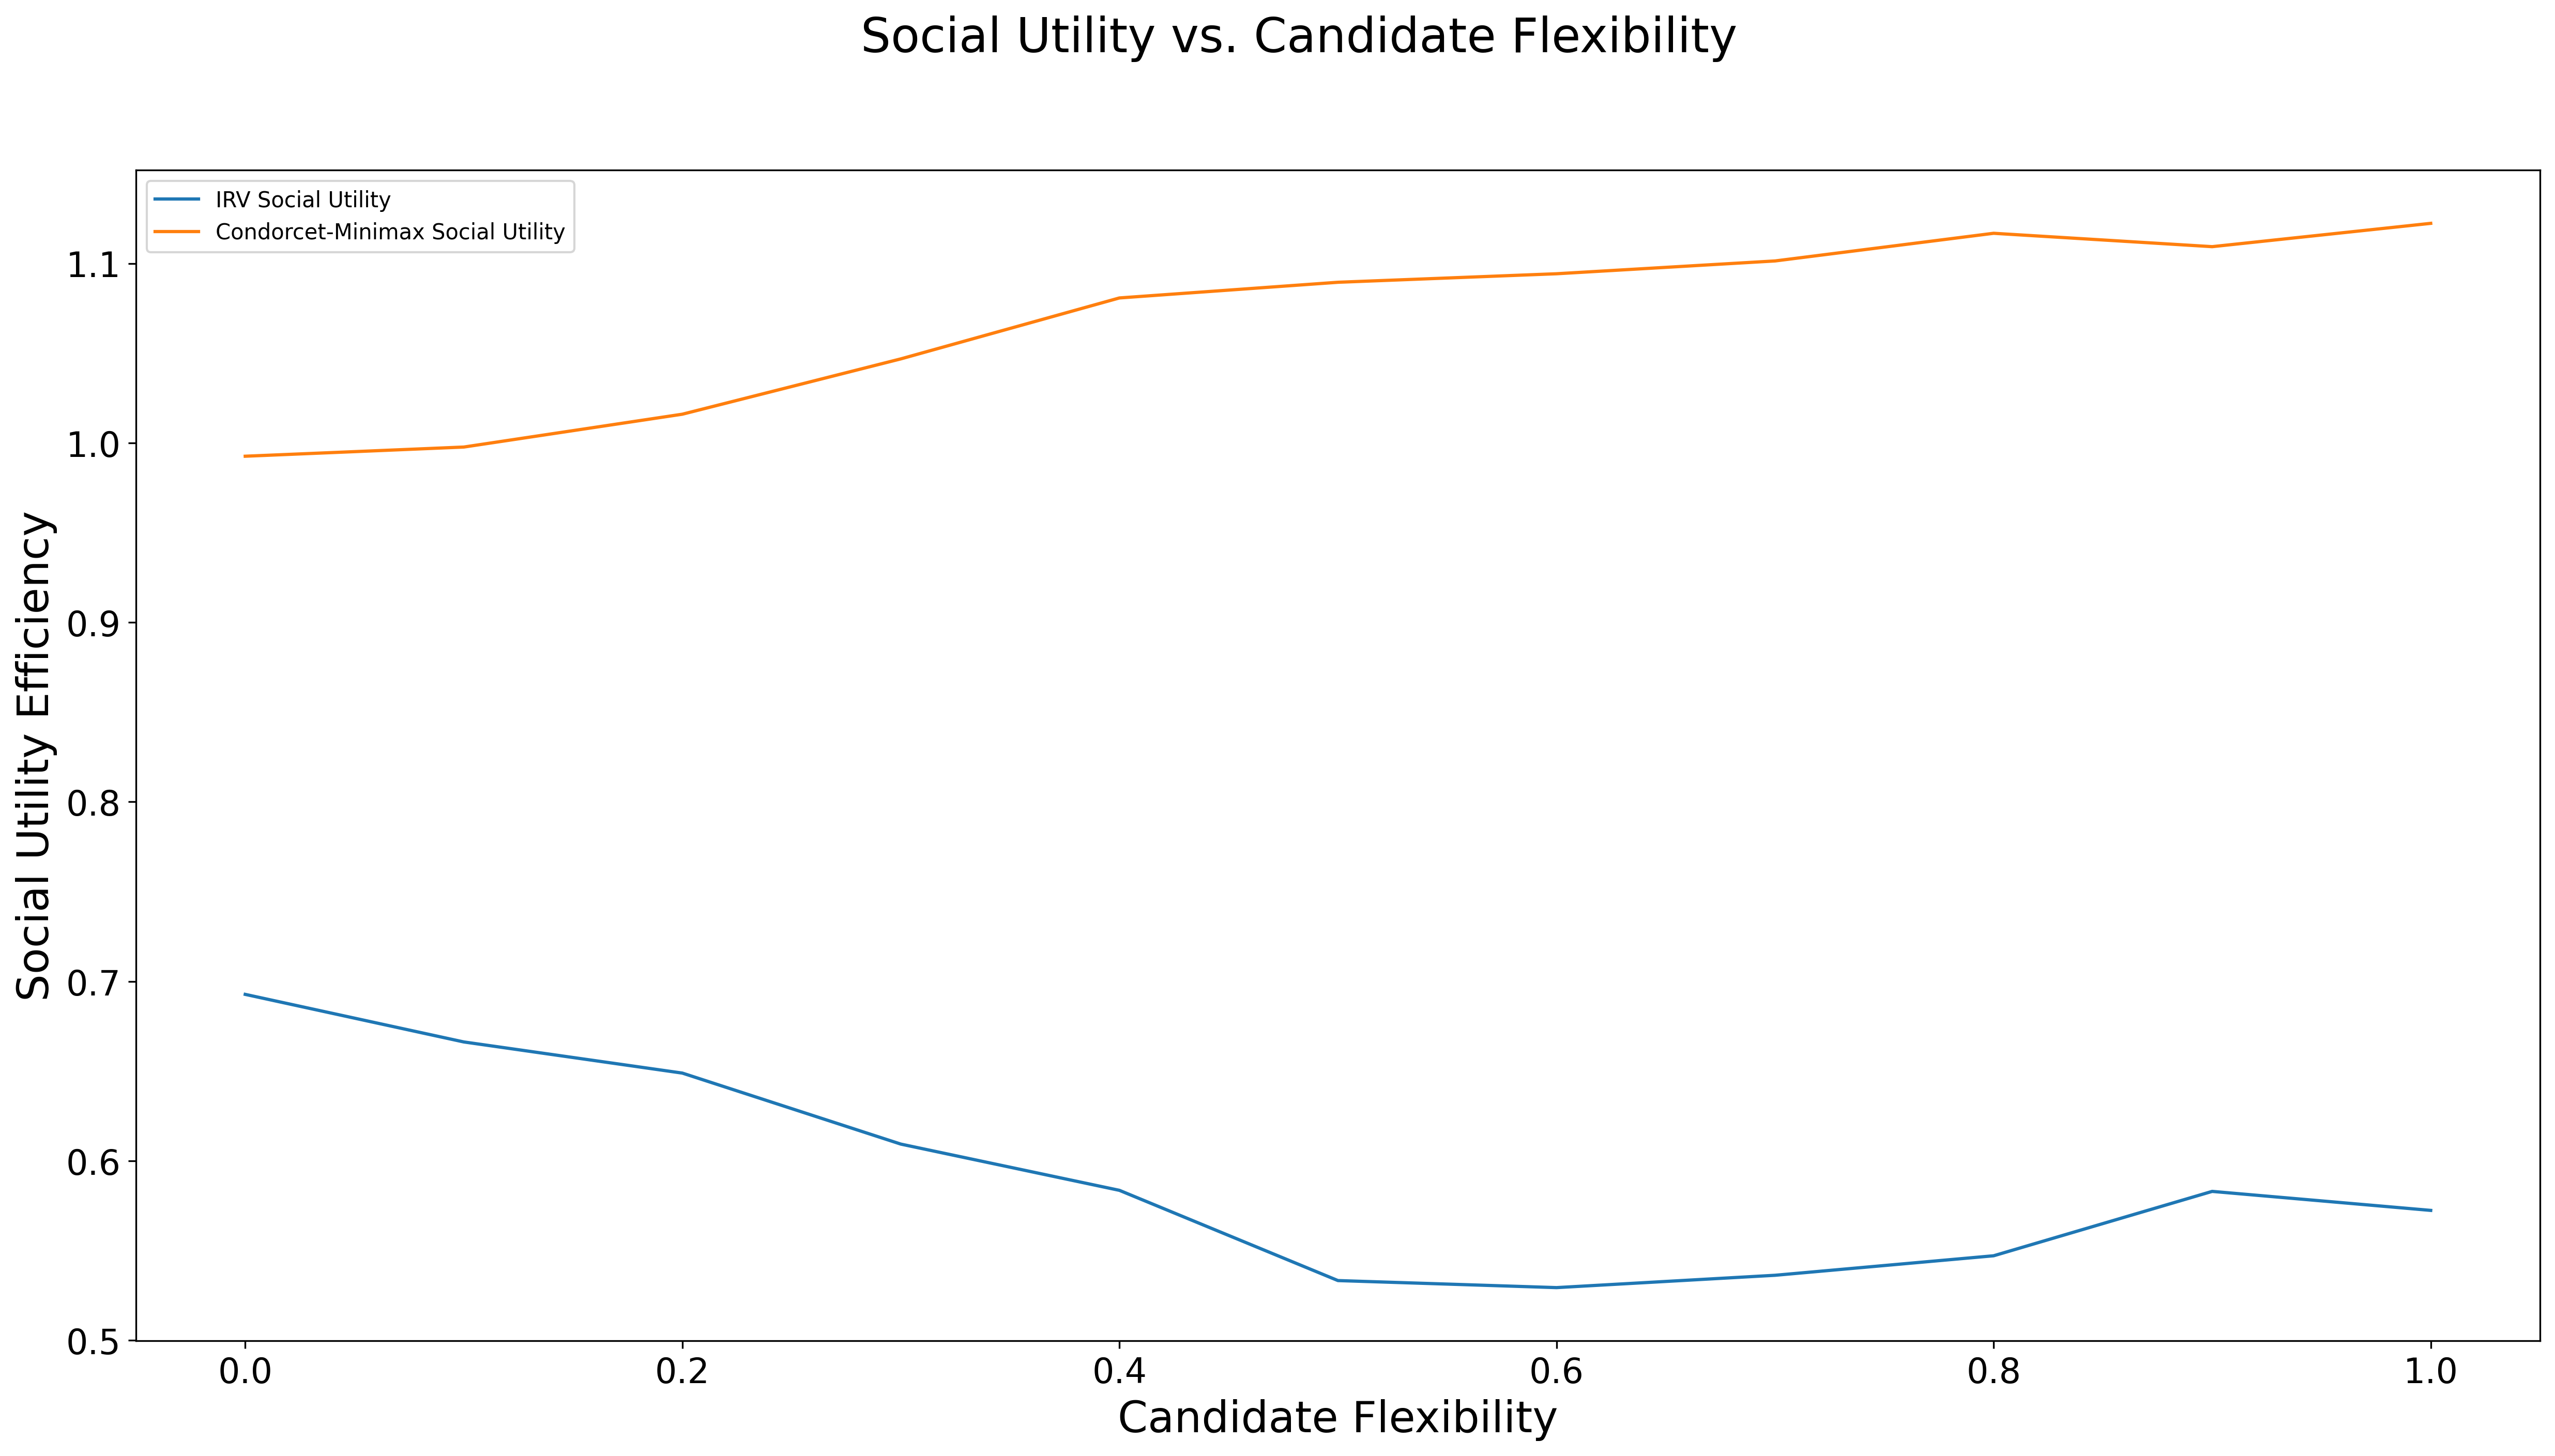

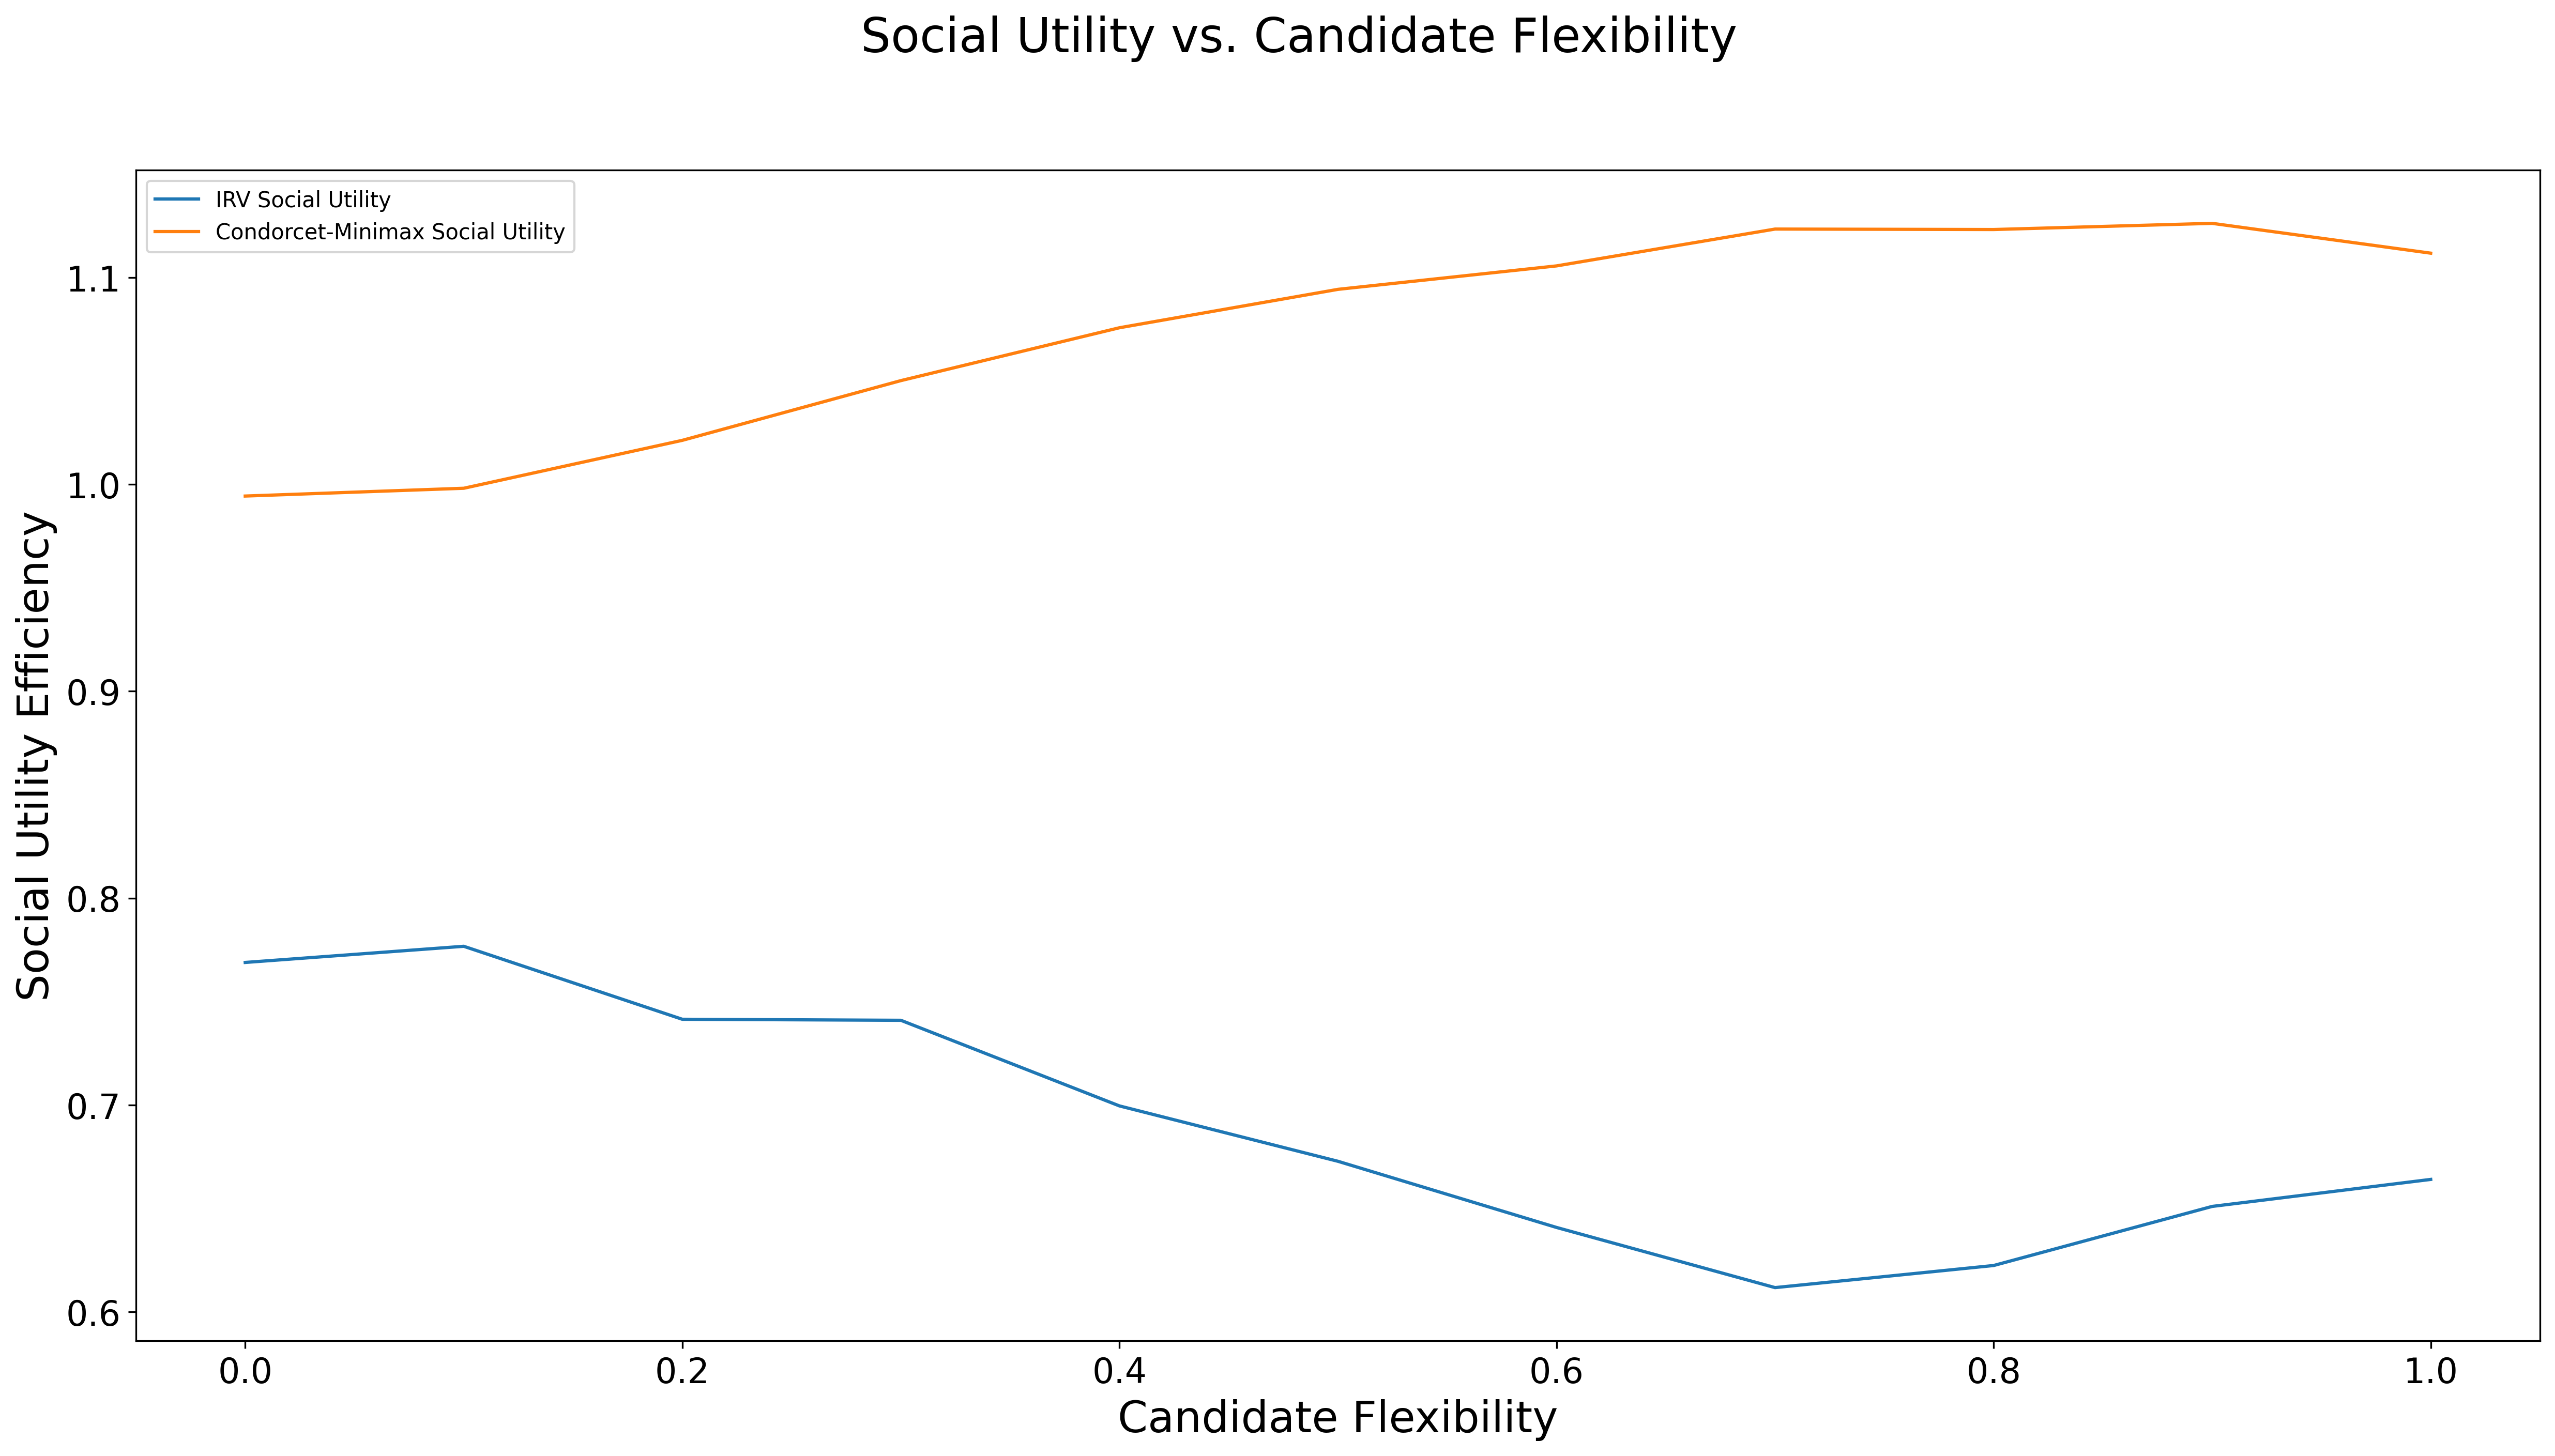

In [6]:
def make_sucf_plot(candidate_variance: float):
    version="v29"
    flex_range = np.arange(0, 1.01, .1)
    qv_range = np.arange(0, .1, .02)

    n_races = 1000
    n_voters = 1000

    irv_flex_data = [run_strategic_races(version, "IRV", candidate_variance, .01, flex, n_races, n_voters) for flex in flex_range]
    h2h_flex_data = [run_strategic_races(version, "H2H", candidate_variance, .01, flex, n_races, n_voters) for flex in flex_range]
    h2h_qv_data = [run_strategic_races(version, "H2H", candidate_variance, qv, .07, n_races, n_voters) for qv in qv_range]

    save_results(f"exp/{version}/irv_flex_data", irv_flex_data)
    save_results(f"exp/{version}/h2h_flex_data", h2h_flex_data)
    save_results(f"exp/{version}/h2h_qv_data", h2h_qv_data)

    irv_flex_values = [compute_SUE(rr) for rr in irv_flex_data]
    h2h_flex_values = [compute_SUE(rr) for rr in h2h_flex_data]

    make_line_plot(
        [
            [flex_range, irv_flex_values],
            [flex_range, h2h_flex_values],
        ],
                   "Social Utility vs. Candidate Flexibility",
                   ["IRV Social Utility", "Condorcet-Minimax Social Utility"],
                   "Candidate Flexibility", "Social Utility Efficiency")

    plt.savefig("exp/%s/sucf.cv.%.2f.png" % (version, candidate_variance))

make_sucf_plot(.5)
make_sucf_plot(.75)
make_sucf_plot(1.0)

In [7]:
def make_tie_flex_plot():
    data =  \
    """H2H        flex 0.00 cv 0.50 SUE  0.991   1.10
    H2H        flex 0.10 cv 0.50 SUE  0.997   1.40
    H2H        flex 0.20 cv 0.50 SUE  1.031   2.50
    H2H        flex 0.30 cv 0.50 SUE  1.051   4.90
    H2H        flex 0.40 cv 0.50 SUE  1.069   7.80
    H2H        flex 0.50 cv 0.50 SUE  1.089  10.00
    H2H        flex 0.60 cv 0.50 SUE  1.086  11.80
    H2H        flex 0.70 cv 0.50 SUE  1.090  13.10
    H2H        flex 0.80 cv 0.50 SUE  1.095  15.80
    H2H        flex 0.90 cv 0.50 SUE  1.093  15.80
    H2H        flex 1.00 cv 0.50 SUE  1.094  18.40
    """

    lines = data.split("\n")
    lines

    t = []
    x = []
    for l in lines:
        f = l.split()
        if len(f) >= 8:
            t.append(float(f[7]))
            x.append(float(f[2]))


    make_line_plot([[x, t]],
                   "Chance of Condorcet-Tie vs Candidate Flexibility with Strategy",
                   ["Percent Chance of tie"],
                   "Candidate Ideological Flexibility",
                   "Chance of Tie"
                   )
# make_tie_flex_plot()

In [8]:
def make_tie_qv_plot():
    data = """
0.00  18.40
0.02  4.40
0.04  0.90
0.06  0.50
0.08  0.40
0.10  0.10
    """
    lines = data.split("\n")
    t = []
    x = []
    for l in lines:
        f = l.split()
        if len(f) >= 2:
            t.append(float(f[1]))
            x.append(float(f[0]))


    make_line_plot([[x, t]],
                   "Chance of Condorcet-Tie vs Candidate Quality Variance with Strategy",
                   ["Percent Chance of tie"],
                   "Variance in Quality of Candidate (stddev)",
                   "Chance of Tie"
                   )

# make_tie_qv_plot()

